In [118]:
%matplotlib inline

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
from gymnasium import Env, spaces
from scipy.special import comb
from collections import defaultdict

In [120]:
# Load the parameters from the pickle file
with open('pickles/anonbank_best_fit_params.pkl', 'rb') as f:
    best_fit_params_df = pickle.load(f)

# Convert to dictionary for easier access
best_fit_params_dict = best_fit_params_df.set_index('param_name').T.to_dict()

best_fit_params_dict

{('1', 'COMPLEX'): {'shape': 1.214960359497789,
  'loc': -6.43006717763892,
  'scale': 107.29065148469789},
 ('1', 'SIMPLE'): {'shape': 0.8730464230836799,
  'loc': -18.81216413263904,
  'scale': 125.46378302666686},
 ('2', 'COMPLEX'): {'shape': 1.025678942745753,
  'loc': -4.806412598886724,
  'scale': 101.20889024937449},
 ('2', 'SIMPLE'): {'shape': 0.8338496982819321,
  'loc': -8.97654648869145,
  'scale': 150.28787524753483},
 ('1', 'COMPLEX_NOLOW'): {'shape': 1.1455358142639027,
  'loc': 10.920950897381609,
  'scale': 116.55293254226876},
 ('1', 'SIMPLE_NOLOW'): {'shape': 0.9216145843793387,
  'loc': 9.441854384689153,
  'scale': 111.53017240822325},
 ('2', 'COMPLEX_NOLOW'): {'shape': 1.0882709227532887,
  'loc': 11.367026593641773,
  'scale': 93.3275789227768},
 ('2', 'SIMPLE_NOLOW'): {'shape': 0.918529262833772,
  'loc': 9.315220497826276,
  'scale': 131.2794207987643},
 'SIMPLE': {'shape': 1.0504388160598739,
  'loc': -2.846758403840244,
  'scale': 42.90266397968547},
 'COMPLEX

In [121]:
with open('pickles/anonbank_lognorm_params.pkl', 'rb') as f:
    lognorm_params_df = pickle.load(f)
    
lognorm_params_dict = lognorm_params_df.set_index('param_name').T.to_dict()

lognorm_params_dict

{('1', 'COMPLEX'): {'mu': 4.6755415208149325,
  'sigma': 0.011323646523065594,
  'loc': -6.43006717763892},
 ('1', 'SIMPLE'): {'mu': 4.832017135463374,
  'sigma': 0.006958469079704907,
  'loc': -18.81216413263904},
 ('2', 'COMPLEX'): {'mu': 4.617186601308905,
  'sigma': 0.010134016947128502,
  'loc': -4.806412598886724},
 ('2', 'SIMPLE'): {'mu': 5.0125526231624855,
  'sigma': 0.005548307071802354,
  'loc': -8.97654648869145},
 ('1', 'COMPLEX_NOLOW'): {'mu': 4.758345526403055,
  'sigma': 0.009828222477376476,
  'loc': 10.920950897381609},
 ('1', 'SIMPLE_NOLOW'): {'mu': 4.71429515885142,
  'sigma': 0.008263224492175078,
  'loc': 9.441854384689153},
 ('2', 'COMPLEX_NOLOW'): {'mu': 4.536115658201609,
  'sigma': 0.011660368179008536,
  'loc': 11.367026593641773},
 ('2', 'SIMPLE_NOLOW'): {'mu': 4.8773280348187535,
  'sigma': 0.006996664183970399,
  'loc': 9.315220497826276},
 'SIMPLE': {'mu': 3.7589339214345716,
  'sigma': 0.024480564633599006,
  'loc': -2.846758403840244},
 'COMPLEX': {'mu'

In [122]:
# Global variables

# Queue size
MAX_QUEUE_SIZE = 20

# Discount factor for future rewards
DISCOUNT = 0.95

# Penalty for dropping calls (when queue is full)
DROP_PENALTY = 3600.0 # 1 hour in seconds

# State space: (queue 1 size, queue 2 size, call type)
STATE_SPACE = (MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1, 2)

# Call type: 0 = simple, 1 = complex
CALL_TYPE = [0, 1]

# Actions: 0 = route to queue 1, 1 = route to queue 2
ACTIONS = [0, 1]

# Arrival parameters for simple and complex calls
ARRIVAL_SIMPLE_MU = lognorm_params_dict['SIMPLE']['mu']
ARRIVAL_SIMPLE_SIGMA = lognorm_params_dict['SIMPLE']['sigma']
ARRIVAL_SIMPLE_LOC = lognorm_params_dict['SIMPLE']['loc']

ARRIVAL_COMPLEX_MU = lognorm_params_dict['COMPLEX']['mu']
ARRIVAL_COMPLEX_SIGMA = lognorm_params_dict['COMPLEX']['sigma']
ARRIVAL_COMPLEX_LOC = lognorm_params_dict['COMPLEX']['loc']

SERVICE_SIMPLE_1_MU = lognorm_params_dict[('1', 'SIMPLE')]['mu']
SERVICE_SIMPLE_1_SIGMA = lognorm_params_dict[('1', 'SIMPLE')]['sigma']
SERVICE_SIMPLE_1_LOC = lognorm_params_dict[('1', 'SIMPLE')]['loc']
SERVICE_COMPLEX_1_MU = lognorm_params_dict[('1', 'COMPLEX')]['mu']
SERVICE_COMPLEX_1_SIGMA = lognorm_params_dict[('1', 'COMPLEX')]['sigma']
SERVICE_COMPLEX_1_LOC = lognorm_params_dict[('1', 'COMPLEX')]['loc']

SERVICE_SIMPLE_2_MU = lognorm_params_dict[('2', 'SIMPLE')]['mu']
SERVICE_SIMPLE_2_SIGMA = lognorm_params_dict[('2', 'SIMPLE')]['sigma']
SERVICE_SIMPLE_2_LOC = lognorm_params_dict[('2', 'SIMPLE')]['loc']
SERVICE_COMPLEX_2_MU = lognorm_params_dict[('2', 'COMPLEX')]['mu']
SERVICE_COMPLEX_2_SIGMA = lognorm_params_dict[('2', 'COMPLEX')]['sigma']
SERVICE_COMPLEX_2_LOC = lognorm_params_dict[('2', 'COMPLEX')]['loc']

def mean_shifted_lognormal(mu, sigma, loc):
    """
    Calculate mean of shifted lognormal distribution:
    E[X] = exp(mu + sigma^2 / 2) + loc
    """
    return np.exp(mu + (sigma**2) / 2) + loc

# Arrival rates

ARRIVAL_SIMPLE = mean_shifted_lognormal(
    ARRIVAL_SIMPLE_MU,
    ARRIVAL_SIMPLE_SIGMA,
    ARRIVAL_SIMPLE_LOC
)

ARRIVAL_COMPLEX = mean_shifted_lognormal(
    ARRIVAL_COMPLEX_MU,
    ARRIVAL_COMPLEX_SIGMA,
    ARRIVAL_COMPLEX_LOC
)

# Service rates

SERVICE_SIMPLE_1 = mean_shifted_lognormal(
    SERVICE_SIMPLE_1_MU,
    SERVICE_SIMPLE_1_SIGMA,
    SERVICE_SIMPLE_1_LOC
)

SERVICE_SIMPLE_2 = mean_shifted_lognormal(
    SERVICE_SIMPLE_2_MU,
    SERVICE_SIMPLE_2_SIGMA,
    SERVICE_SIMPLE_2_LOC
)

SERVICE_COMPLEX_1 = mean_shifted_lognormal(
    SERVICE_COMPLEX_1_MU,
    SERVICE_COMPLEX_1_SIGMA,
    SERVICE_COMPLEX_1_LOC
)

SERVICE_COMPLEX_2 = mean_shifted_lognormal(
    SERVICE_COMPLEX_2_MU,
    SERVICE_COMPLEX_2_SIGMA,
    SERVICE_COMPLEX_2_LOC
)

In [123]:
print(f"ARRIVAL_SIMPLE: {ARRIVAL_SIMPLE}, ARRIVAL_COMPLEX: {ARRIVAL_COMPLEX}")
print(f"SERVICE_SIMPLE_1: {SERVICE_SIMPLE_1}, SERVICE_SIMPLE_2: {SERVICE_SIMPLE_2}")
print(f"SERVICE_COMPLEX_1: {SERVICE_COMPLEX_1}, SERVICE_COMPLEX_2: {SERVICE_COMPLEX_2}") 

ARRIVAL_SIMPLE: 40.068763243462236, ARRIVAL_COMPLEX: 99.34173344076834
SERVICE_SIMPLE_1: 106.65465642729778, SERVICE_SIMPLE_2: 141.3136419859323
SERVICE_COMPLEX_1: 100.86746319788303, SERVICE_COMPLEX_2: 96.4076747743812


In [124]:
# Lognormal expected value calculation

def expected_waiting_time_lognormal(q_size, p_simple, mean_s, mean_c):
    """
    Calculate expected waiting time for a queue with q_size calls,
    each call being simple with probability p_simple,
    using direct mean service times for simple and complex calls.
    """
    wait = 0.0
    for k in range(q_size + 1):
        # Binomial probability of k simple calls in the queue
        prob = comb(q_size, k) * (p_simple ** k) * ((1 - p_simple) ** (q_size - k))
        # Waiting time if k simple and (q_size - k) complex ahead
        wait_k = k * mean_s + (q_size - k) * mean_c
        wait += prob * wait_k

    # Add mean service time for the current arriving call (assumed simple here)
    wait += mean_s
    return wait


In [125]:
# Example usage to calculate expected waiting time for queue 1:

p_simple = ARRIVAL_SIMPLE / (ARRIVAL_SIMPLE + ARRIVAL_COMPLEX)

mean_s1 = SERVICE_SIMPLE_1

mean_c1 = SERVICE_COMPLEX_1

q1 = 10 # Example queue size

expected_wait = expected_waiting_time_lognormal(q1, p_simple, mean_s1, mean_c1)
print(f"Expected waiting time at queue 1: {expected_wait:.4f}")

# Compare with queue 2

mean_s2 = SERVICE_SIMPLE_2

mean_c2 = SERVICE_COMPLEX_2

expected_wait = expected_waiting_time_lognormal(q1, p_simple, mean_s2, mean_c2) # Assuming same queue size for simplicity
print(f"Expected waiting time at queue 2: {expected_wait:.4f}")

Expected waiting time at queue 1: 1131.9626
Expected waiting time at queue 2: 1234.4572


In [130]:
class CallCentreMDPEnv:
    """
    RL environment for a two-queue call centre using proper queueing logic and stochastic service times.
    State: (q1_length, q2_length, call_type)
    Action: 0 = route to queue 1, 1 = queue 2
    """
    def __init__(self, max_queue=10, drop_penalty=100.0, seed=1901448):
        self.max_queue = max_queue
        self.drop_penalty = drop_penalty
        self.state = None
        self.p_simple = ARRIVAL_SIMPLE / (ARRIVAL_SIMPLE + ARRIVAL_COMPLEX)  # Probability of simple call
        # We'll track each queue as a list of remaining service times
        self.queue1 = []
        self.queue2 = []
        self.seed(seed)

    def seed(self, seed=None):
        np.random.seed(seed)
        random.seed(seed)

    def _sample_service_time(self, qnum, call_type):
        # qnum = 1 or 2; call_type = 0 (simple) or 1 (complex)
        if qnum == 1:
            if call_type == 0:
                return np.random.lognormal(SERVICE_SIMPLE_1_MU, SERVICE_SIMPLE_1_SIGMA) + SERVICE_SIMPLE_1_LOC
            else:
                return np.random.lognormal(SERVICE_COMPLEX_1_MU, SERVICE_COMPLEX_1_SIGMA) + SERVICE_COMPLEX_1_LOC
        else:
            if call_type == 0:
                return np.random.lognormal(SERVICE_SIMPLE_2_MU, SERVICE_SIMPLE_2_SIGMA) + SERVICE_SIMPLE_2_LOC
            else:
                return np.random.lognormal(SERVICE_COMPLEX_2_MU, SERVICE_COMPLEX_2_SIGMA) + SERVICE_COMPLEX_2_LOC

    def reset(self):
        # Start with empty queues and a random call type
        self.queue1 = []
        self.queue2 = []
        call_type = np.random.choice([0, 1], p=[p_simple, 1 - p_simple])
        self.state = (0, 0, call_type)
        return self.state

    def _advance_time(self, time_step=1.0):
        # Simulate the passage of one "step": decrement service times and remove calls that finish.
        self.queue1 = [max(0.0, s - time_step) for s in self.queue1]
        self.queue2 = [max(0.0, s - time_step) for s in self.queue2]
        self.queue1 = [s for s in self.queue1 if s > 0.0]
        self.queue2 = [s for s in self.queue2 if s > 0.0]
        
    def _calculate_expected_waiting_time(self, q_pos, q_num, call_type):
        """
        Calculate expected waiting time for a call at given position in queue
        """
        if q_pos == 0:
            return 0.0 # No waiting time if first in queue
        
        if q_num == 1:
            mean_s = SERVICE_SIMPLE_1 if call_type == 0 else SERVICE_COMPLEX_1
            mean_c = SERVICE_COMPLEX_1 if call_type == 0 else SERVICE_SIMPLE_1
        else:
            mean_s = SERVICE_SIMPLE_2 if call_type == 0 else SERVICE_COMPLEX_2
            mean_c = SERVICE_COMPLEX_2 if call_type == 0 else SERVICE_SIMPLE_2
            
        if call_type == 0:
            own_service_time = SERVICE_SIMPLE_1 
        else:
            own_service_time = SERVICE_COMPLEX_1
            
        expected_service_ahead = q_pos * (
            self.p_simple * mean_s + (1 - self.p_simple) * mean_c
        )
        
        return expected_service_ahead + own_service_time

    def step(self, action):
        q1, q2, call_type = self.state
        dropped = False
        # Check if chosen queue is full
        if action == 0 and len(self.queue1) >= self.max_queue:
            reward = -self.drop_penalty
            dropped = True
        elif action == 1 and len(self.queue2) >= self.max_queue:
            reward = -self.drop_penalty
            dropped = True
        else:
            # Add call to the chosen queue, sample service time
            if action == 0:
                q_pos = len(self.queue1)
                self.queue1.append(self._sample_service_time(1, call_type))
                expected_wait = self._calculate_expected_waiting_time(q_pos, 1, call_type)
                reward = -expected_wait
            else:
                q_pos = len(self.queue2)
                self.queue2.append(self._sample_service_time(2, call_type))
                expected_wait = self._calculate_expected_waiting_time(q_pos, 2, call_type)
                reward = -expected_wait
            dropped = False

        # Advance service by one step (simulate in discrete time steps)
        self._advance_time(1.0)
        new_q1 = len(self.queue1)
        new_q2 = len(self.queue2)
        # Next call type
        next_call_type = np.random.choice([0, 1], p=[p_simple, 1 - p_simple])
        self.state = (new_q1, new_q2, next_call_type)
        # Can define done/termination, but typically infinite horizon: always return False
        done = False
        info = {"dropped": dropped}
        return self.state, reward, done, info

    # def _expected_waiting_time(self, q_size, p_simple, mean_s, mean_c):
    #     wait = 0.0
    #     for k in range(q_size + 1):
    #         prob = comb(q_size, k) * (p_simple**k) * ((1 - p_simple)**(q_size-k))
    #         wait_k = k * mean_s + (q_size - k) * mean_c
    #         wait += prob * wait_k
    #     wait += mean_s  # Assume incoming call is simple; adjust if needed
    #     return wait

# Instantiate and test the environment
env = CallCentreMDPEnv()
obs = env.reset()
print(f"First state: {obs}")
for _ in range(5):
    action = np.random.choice([0,1])
    obs, reward, done, info = env.step(action)
    print(f"Obs: {obs}, Reward: {reward:.2f}, Dropped: {info['dropped']}")




First state: (0, 0, np.int64(1))
Obs: (0, 1, np.int64(1)), Reward: -0.00, Dropped: False
Obs: (1, 1, np.int64(1)), Reward: -0.00, Dropped: False
Obs: (1, 2, np.int64(0)), Reward: -229.27, Dropped: False
Obs: (2, 2, np.int64(1)), Reward: -209.19, Dropped: False
Obs: (3, 2, np.int64(1)), Reward: -310.85, Dropped: False


Episode 500/10000 | Avg Reward (last 500): -562440.65 | Epsilon: 0.779
Episode 1000/10000 | Avg Reward (last 500): -560622.51 | Epsilon: 0.606
Episode 1500/10000 | Avg Reward (last 500): -559506.26 | Epsilon: 0.472
Episode 2000/10000 | Avg Reward (last 500): -559598.70 | Epsilon: 0.368
Episode 2500/10000 | Avg Reward (last 500): -561413.02 | Epsilon: 0.286
Episode 3000/10000 | Avg Reward (last 500): -564220.53 | Epsilon: 0.223
Episode 3500/10000 | Avg Reward (last 500): -567010.79 | Epsilon: 0.174
Episode 4000/10000 | Avg Reward (last 500): -569454.28 | Epsilon: 0.135
Episode 4500/10000 | Avg Reward (last 500): -572441.20 | Epsilon: 0.105
Episode 5000/10000 | Avg Reward (last 500): -578816.17 | Epsilon: 0.082
Episode 5500/10000 | Avg Reward (last 500): -577855.98 | Epsilon: 0.064
Episode 6000/10000 | Avg Reward (last 500): -577060.96 | Epsilon: 0.050
Episode 6500/10000 | Avg Reward (last 500): -576440.17 | Epsilon: 0.039
Episode 7000/10000 | Avg Reward (last 500): -574508.57 | Epsilon:

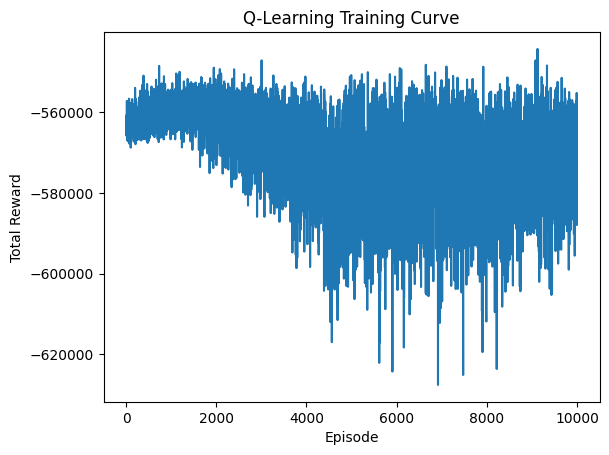

In [132]:
def q_learning(
    env,
    num_episodes=5000,
    max_steps_per_episode=200,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_min=0.1,
    epsilon_decay=0.995
):
    """
    Tabular Q-learning agent for discrete environments.
    - env: Your environment object, with .reset() and .step(action)
    - num_episodes: Number of training episodes
    - max_steps_per_episode: Steps per episode before reset
    - alpha: Learning rate
    - gamma: Discount factor
    - epsilon_start: Initial exploration rate
    - epsilon_min: Minimum epsilon for exploration
    - epsilon_decay: Decay factor for epsilon after each episode
    """

    # Q-table: maps state tuples to numpy array of Q-values for each action
    Q = defaultdict(lambda: np.zeros(2))

    episode_rewards = []
    epsilon = epsilon_start

    for episode in range(num_episodes):
        state = env.reset()
        state = tuple(state)  # for dict key

        total_reward = 0

        for t in range(max_steps_per_episode):
            # Epsilon-greedy policy
            if random.random() < epsilon:
                action = random.choice([0, 1])
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, info = env.step(action)
            next_state = tuple(next_state)

            # Q-learning update
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next_action]
            Q[state][action] += alpha * (td_target - Q[state][action])

            state = next_state
            total_reward += reward

            if done:
                break

        # Decay epsilon after each episode
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)

        # Progress log (optional)
        if (episode + 1) % 500 == 0:
            avg_reward = np.mean(episode_rewards[-500:])
            print(f"Episode {episode+1}/{num_episodes} | Avg Reward (last 500): {avg_reward:.2f} | Epsilon: {epsilon:.3f}")

    return Q, episode_rewards

# Example usage:
env = CallCentreMDPEnv(max_queue=MAX_QUEUE_SIZE, drop_penalty=DROP_PENALTY)
Q_table, rewards = q_learning(env, epsilon_decay=0.9995, epsilon_min=0.01, num_episodes=10000)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Training Curve')
plt.show()

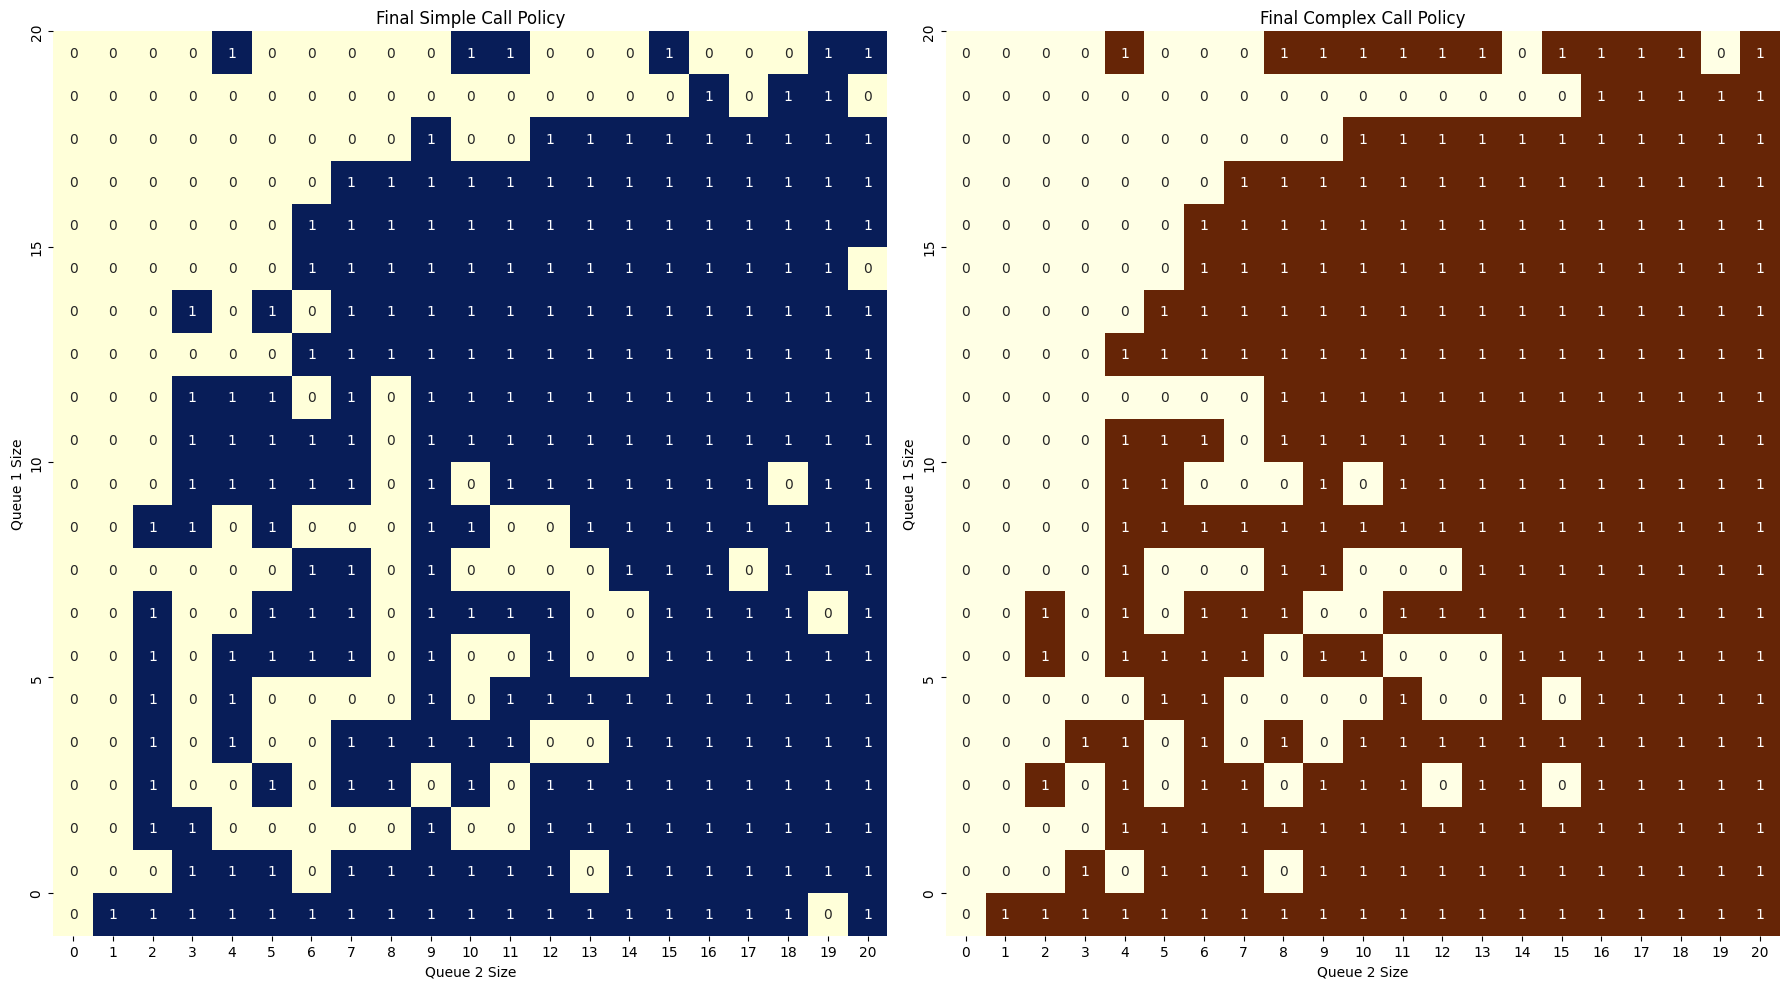

In [107]:
# Initialize policy arrays
policy_simple = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
policy_complex = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)

# Fill arrays with best actions from Q_table
for q1 in range(MAX_QUEUE_SIZE + 1):
    for q2 in range(MAX_QUEUE_SIZE + 1):
        # Simple call policy
        s_simple = (q1, q2, 0)
        if s_simple in Q_table:
            policy_simple[q1, q2] = np.argmax(Q_table[s_simple])
        # Complex call policy
        s_complex = (q1, q2, 1)
        if s_complex in Q_table:
            policy_complex[q1, q2] = np.argmax(Q_table[s_complex])

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Plot Final Simple Call Policy
sns.heatmap(np.flipud(policy_simple), cmap="YlGnBu", ax=axes[0], annot=np.flipud(policy_simple),
            cbar=False)
axes[0].set_title('Final Simple Call Policy')
axes[0].set_ylabel('Queue 1 Size')
axes[0].set_xlabel('Queue 2 Size')
axes[0].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
axes[0].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))

# Plot Final Complex Call Policy
sns.heatmap(np.flipud(policy_complex), cmap="YlOrBr", ax=axes[1], annot=np.flipud(policy_complex),
            cbar=False)
axes[1].set_title('Final Complex Call Policy')
axes[1].set_ylabel('Queue 1 Size')
axes[1].set_xlabel('Queue 2 Size')
axes[1].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
axes[1].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))

plt.tight_layout()
plt.show()

In [99]:
for q1 in range(3):
    for q2 in range(3):
        for ct in [0, 1]:
            state = (q1, q2, ct)
            if state in Q_table:
                best_action = np.argmax(Q_table[state])
                print(f"State {state} -> Best Action: {best_action}")

State (0, 0, 0) -> Best Action: 1
State (0, 0, 1) -> Best Action: 0
State (0, 1, 0) -> Best Action: 1
State (0, 1, 1) -> Best Action: 0
State (0, 2, 0) -> Best Action: 1
State (0, 2, 1) -> Best Action: 0
State (1, 0, 0) -> Best Action: 1
State (1, 0, 1) -> Best Action: 0
State (1, 1, 0) -> Best Action: 0
State (1, 1, 1) -> Best Action: 0
State (1, 2, 0) -> Best Action: 1
State (1, 2, 1) -> Best Action: 1
State (2, 0, 0) -> Best Action: 0
State (2, 0, 1) -> Best Action: 0
State (2, 1, 0) -> Best Action: 1
State (2, 1, 1) -> Best Action: 0
State (2, 2, 0) -> Best Action: 1
State (2, 2, 1) -> Best Action: 1


### What to implement next:

* Implement Gym Environment
* Implement Q-Learning
* Implement PPO